## MalConv2 Model Execution
This section demonstrates how to load and run the MalConv2 model using the instructions and files from the `MalConv2-main` directory. Code is based on the README instructions.

In [ ]:
import sys
import os
import torch
import numpy as np
import torch.nn.functional as F

# 경로 설정 유연성 확보 (Notebook 실행 위치에 따라 경로가 다를 수 있음)
# MalConv2-main 폴더 찾기
current_dir = os.getcwd()
possible_paths = [
    os.path.join(current_dir, 'MalConv2-main'),         # 작업 설정이 루트일 경우
    os.path.join(current_dir, '../models/MalConv2-main'),      # 작업 설정이 현재 파일 위치(test/)일 경우
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main' # 절대 경로 (fallback)
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path:
        sys.path.append(malconv_path)
    print(f"MalConv2-main path added: {malconv_path}")
else:
    print("Error: Could not find MalConv2-main directory.")

# src 폴더 경로 추가 (preprocess.py 사용을 위해)
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path:
    sys.path.append(src_path)

try:
    # MalConvGCT 및 전처리 함수 임포트
    from MalConvGCT_nocat import MalConvGCT
    from src import preprocess_pe_file
    print("Successfully imported MalConvGCT and preprocess_pe_file")

    # 모델 초기화 (README의 파라미터 참고)
    # channels=256, window_size=256, stride=64 설정
    channels = 256
    window_size = 256
    stride = 64
    embd_size = 8
    
    print("Initializing model...")
    model = MalConvGCT(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)
    
    # 체크포인트 로드
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        # Mac M2(Apple Silicon) 호환성을 위해 map_location='cpu' 사용 권장
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        
        # 가중치 로드
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print("Model weights loaded successfully.")
        else:
            print(f"Warning: 'model_state_dict' not found. Keys: {checkpoint.keys()}")
    else:
        print(f"Warning: Checkpoint file not found at {checkpoint_path}. Running with random weights.")

    # 모델을 평가 모드로 설정
    model.eval()

    # 실제 파일 전처리 및 실행 테스트
    target_file = 'ZoomInstaller.exe'
    
    # 파일 존재 여부 확인 후 진행
    if os.path.exists(target_file):
        print(f"Processing file: {target_file}")
        
        # preprocess_pe_file 함수를 사용하여 입력 데이터 준비
        # mode='default' 사용
        input_tensor = preprocess_pe_file(target_file, mode='default')
        
        print(f"Running inference on input with shape {input_tensor.shape}...")
        
        with torch.no_grad():
            output = model(input_tensor)
            # MalConvGCT returns: (logits, penult, post_conv)
            logits = output[0]
            probabilities = F.softmax(logits, dim=1)
            
        print("\nExecution Complete!")
        print(f"Logits: {logits}")
        
        # 결과 해석
        print("\n[결과 해석]")
        print(f"1. Logits (Raw Score): {logits.tolist()}")
        print(f"2. Probabilities (Softmax): {probabilities.tolist()}")
        print(f"   - Class 0 (Benign/정상): {probabilities[0][0].item():.4f} ({probabilities[0][0].item()*100:.2f}%)")
        print(f"   - Class 1 (Malware/악성): {probabilities[0][1].item():.4f} ({probabilities[0][1].item()*100:.2f}%)")
        
        predicted_class = torch.argmax(probabilities, dim=1).item()
        class_label = "악성 (Malware)" if predicted_class == 1 else "정상 (Benign)"
        print(f"3. 최종 예측: {class_label} (Class {predicted_class})")
        
    else:
        print(f"Error: Target file '{target_file}' not found. Please make sure the file exists in the current directory.")

except ImportError as e:
    print(f"Import Error: {e}")
    print("Make sure MalConv2-main is in the path and src package is accessible.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Config 로드 테스트
from src.utils import load_config
try:
    config = load_config()
    print("Config loaded successfully:")
    print(config)
except Exception as e:
    print(f"Failed to load config: {e}")

In [ ]:
# MalConvGCTDeepShap Class Test
# IMPORTANT: This cell reloads libraries to define necessary classes before running test logic.
# Do not skip.

import sys
import os
import torch
import numpy as np
import shap
import importlib
import src.compute_DeepShap
importlib.reload(src.compute_DeepShap)
from src.compute_DeepShap import MalConvGCTDeepShap, DeepShapExplainer
from src import preprocess_pe_file

print("Library reloaded.")


/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Testing Adversarial Attack & DeepSHAP Comparison ---
Target Files (Max 7): ['Win32.MyLobot.bin', 'win32_emotet.bin', 'Win32.SofacyCarberp.exe', 'Ransomware.WannaCry.exe', 'Locky', 'Rustock_malware.exe', 'win32_avatar']

[1/7] Processing: Win32.MyLobot.bin
[16:37:59] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:37:59] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 8.4800
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 8.1321
    Model Out: 9.9752
    Diff     : 1.843137
    >> FAIL: Additivity Mismatch.
[16:37:59] INFO  : Adversarial Attack Start: Original Size=180224, Padding Size(q)=1802, Iterations(T)=20
[16:37:59] INFO  : Success at iteration 2: Malware Prob = 0.0001
[16:38:00] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:00] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=100.00% -> Adversarial Prob=0.01%
  [A

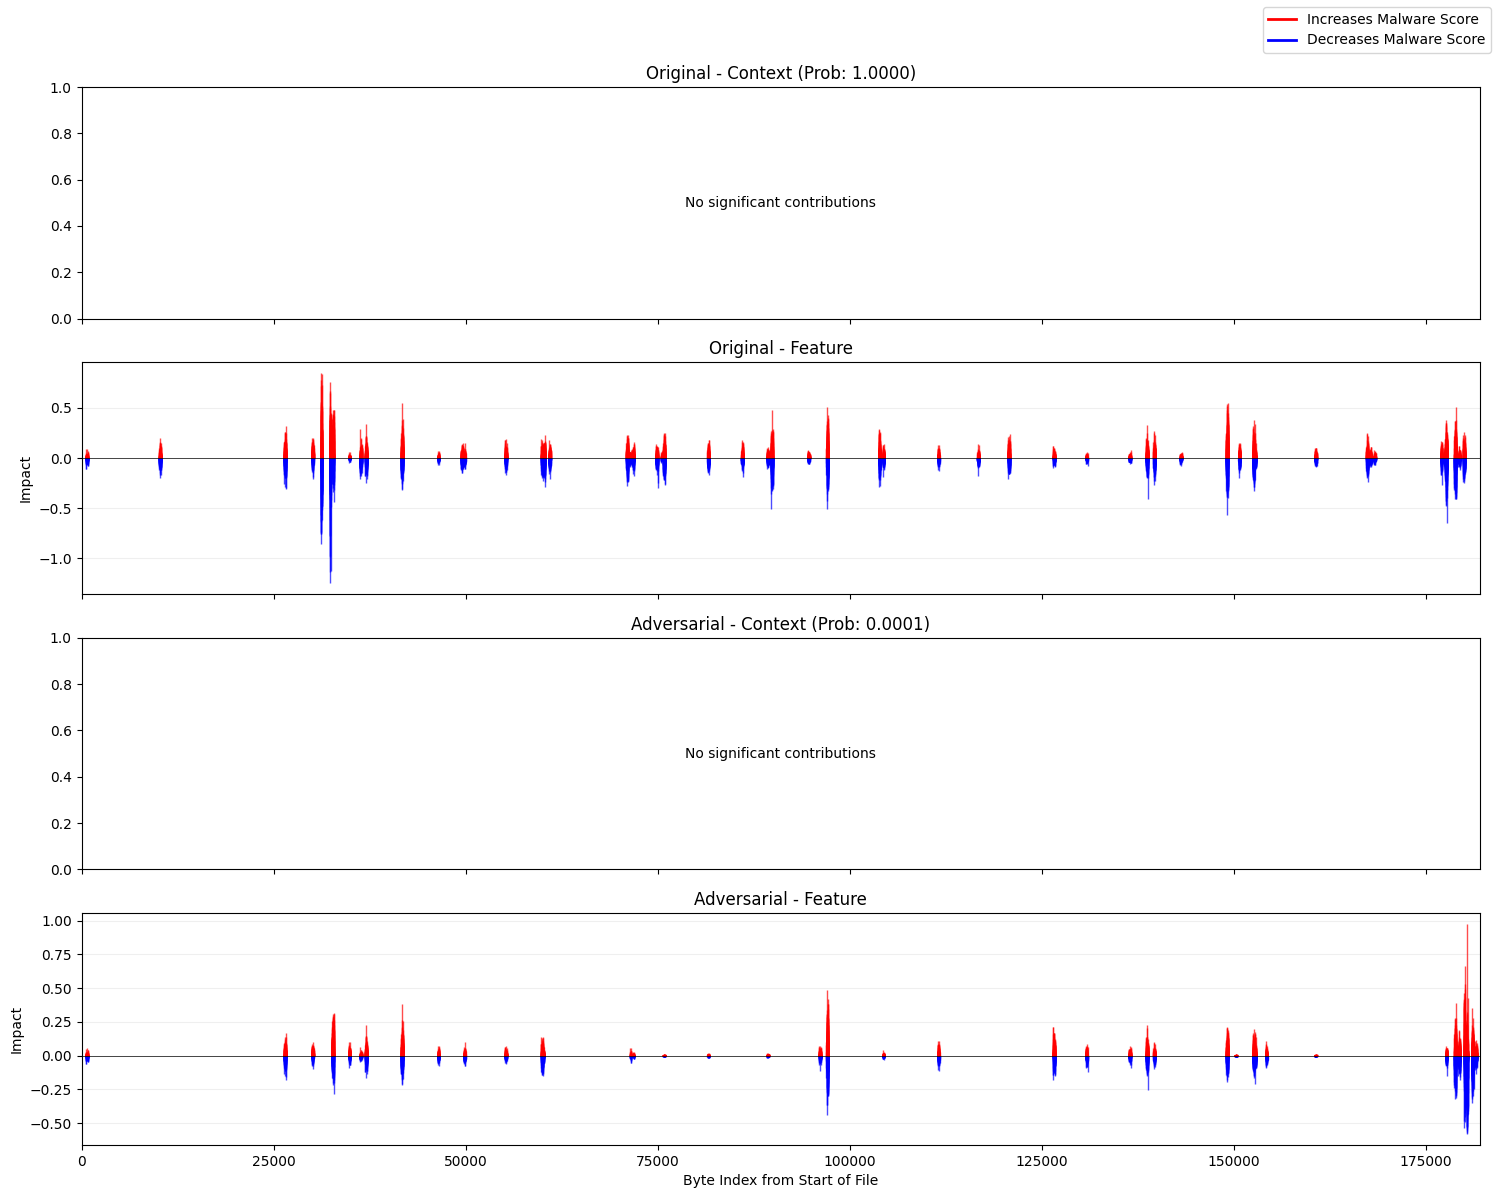


[2/7] Processing: win32_emotet.bin
[16:38:00] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:00] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 1.9154
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 1.5675
    Model Out: 1.8746
    Diff     : 0.307152
    >> PASS: Additivity Verified.
[16:38:00] INFO  : Adversarial Attack Start: Original Size=96535, Padding Size(q)=965, Iterations(T)=20
[16:38:00] INFO  : Iteration 5/20: Malware Prob = 0.9831
[16:38:01] INFO  : Iteration 10/20: Malware Prob = 0.9831
[16:38:01] INFO  : Iteration 15/20: Malware Prob = 0.9831
[16:38:01] INFO  : Iteration 20/20: Malware Prob = 0.9831
[16:38:01] WARNING : Attack Failed to cross threshold after 20 iterations. Final Prob: 0.9831
[16:38:01] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:01] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=98.31

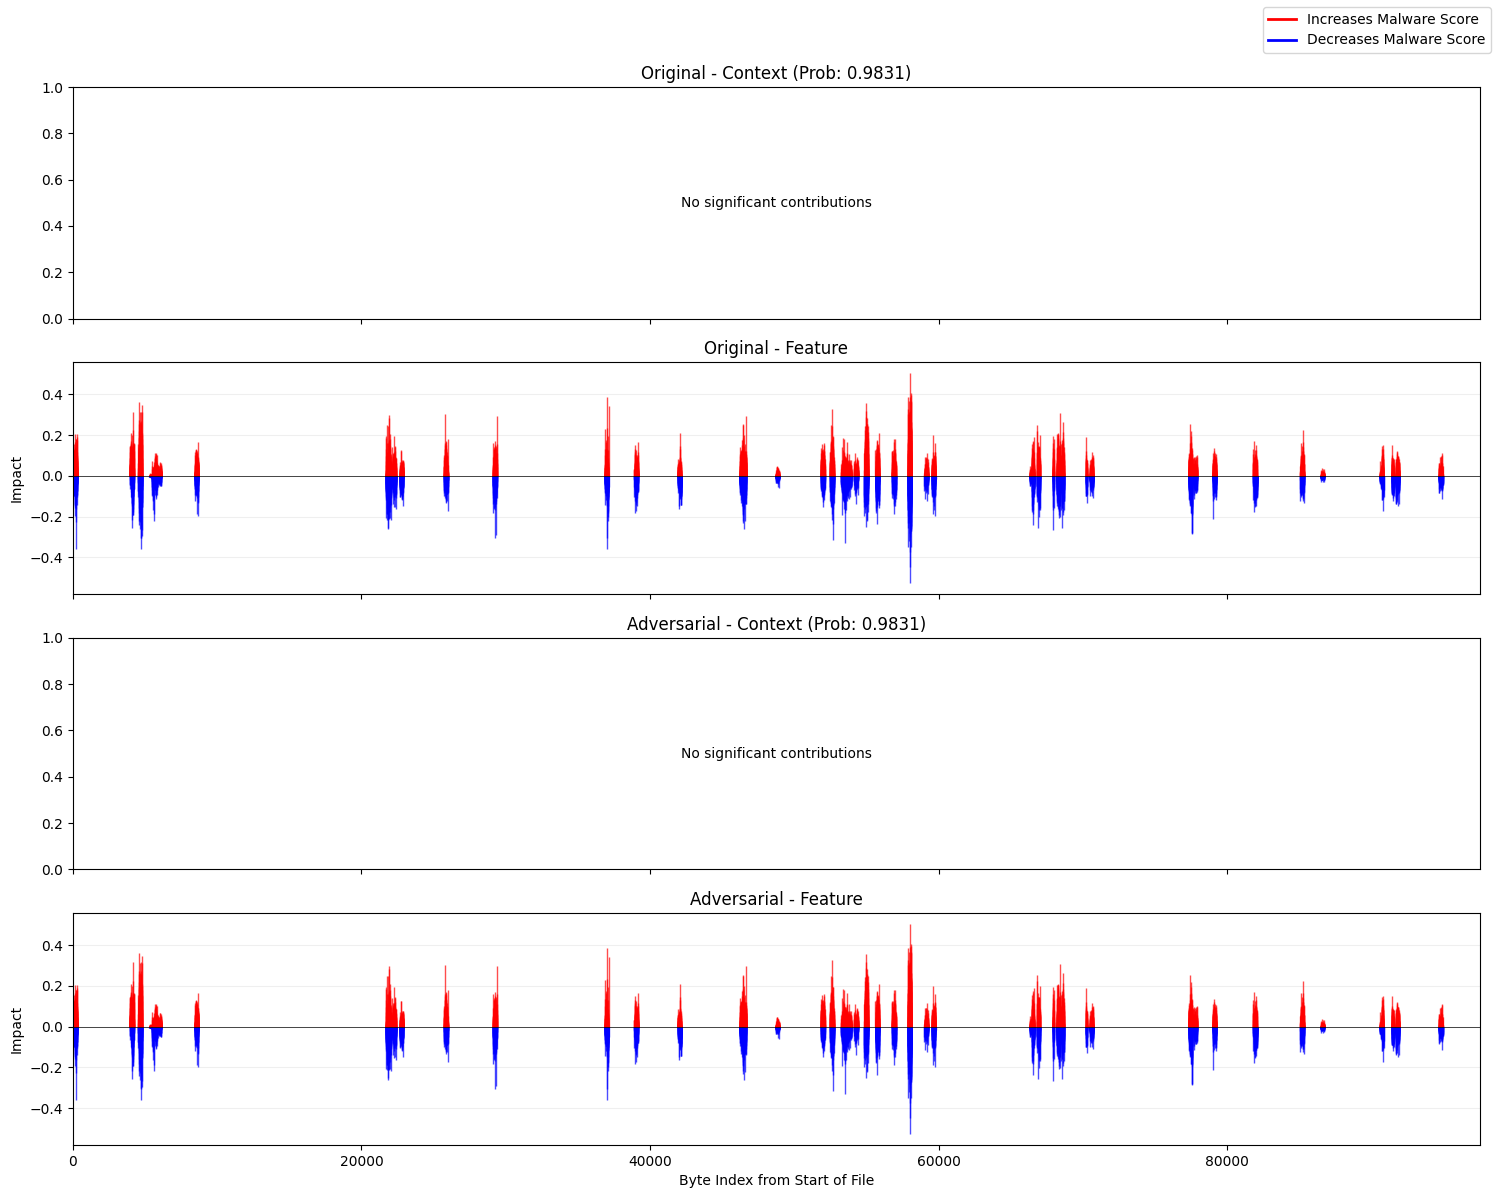


[3/7] Processing: Win32.SofacyCarberp.exe
[16:38:02] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:02] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 2.8497
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 2.5017
    Model Out: 2.2682
    Diff     : 0.233557
    >> PASS: Additivity Verified.
[16:38:02] INFO  : Adversarial Attack Start: Original Size=133632, Padding Size(q)=1336, Iterations(T)=20
[16:38:02] INFO  : Success at iteration 2: Malware Prob = 0.0000
[16:38:02] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:02] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=99.14% -> Adversarial Prob=0.00%
  [Adversarial] Verifiction:
    SHAP Sum : -4.9035
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : -5.2515
    Model Out: -7.0819
    Diff     : 1.830437
    >> FAIL: Additivity M

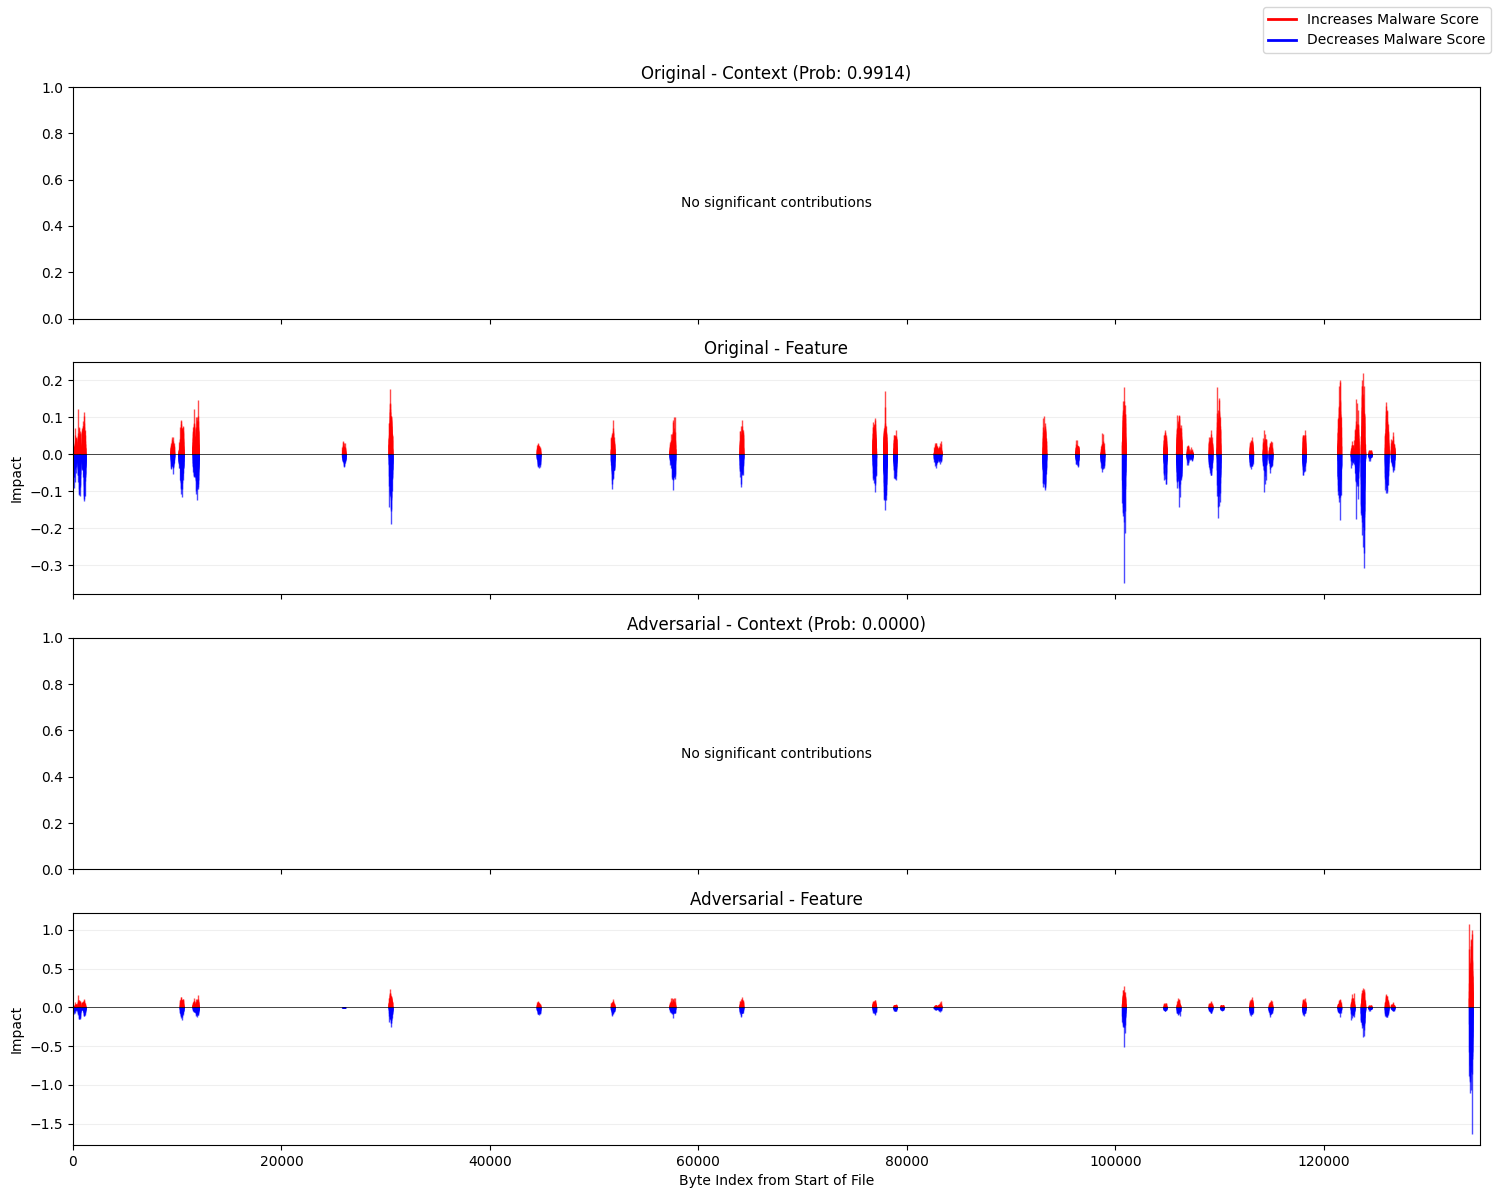


[4/7] Processing: Ransomware.WannaCry.exe
[16:38:05] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:05] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 6.8203
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 6.4723
    Model Out: 7.0755
    Diff     : 0.603137
    >> PASS: Additivity Verified.
[16:38:05] INFO  : Adversarial Attack Start: Original Size=3514368, Padding Size(q)=35143, Iterations(T)=20
[16:38:18] INFO  : Success at iteration 2: Malware Prob = 0.0000
[16:38:20] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:20] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=100.00% -> Adversarial Prob=0.00%
  [Adversarial] Verifiction:
    SHAP Sum : -26.8699
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : -27.2179
    Model Out: -26.1310
    Diff     : 1.086901
    >> FAIL: Additi

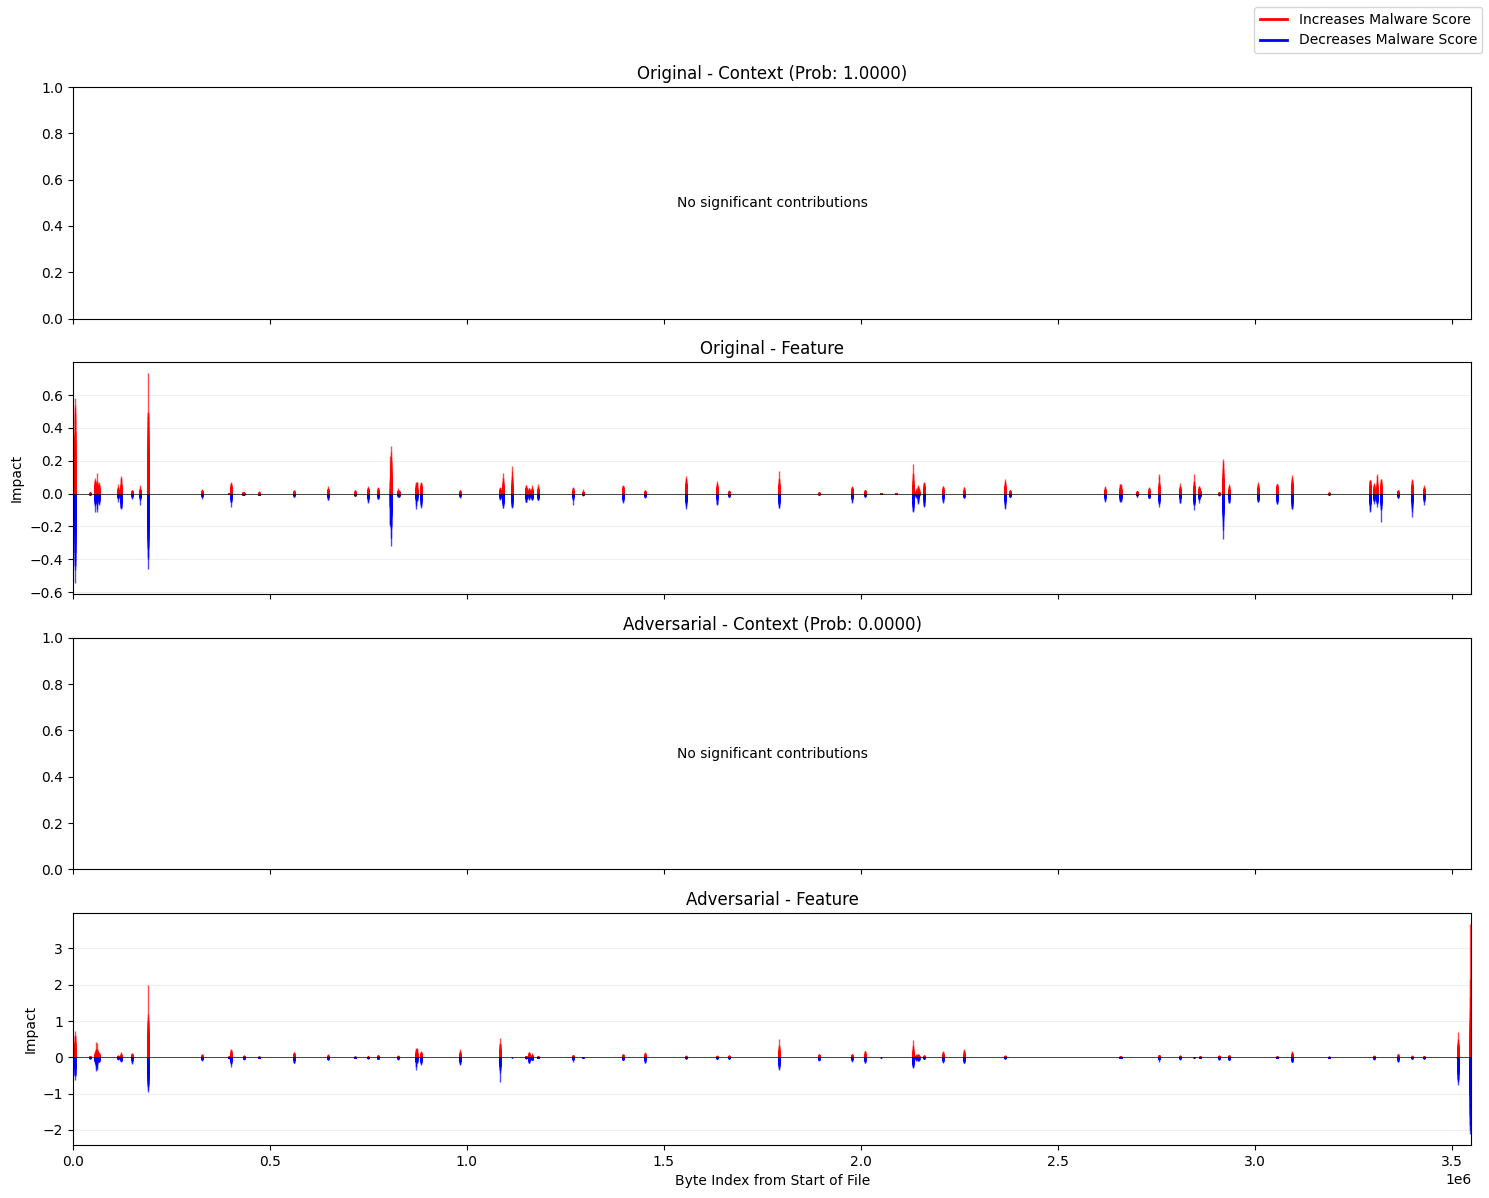


[5/7] Processing: Locky
[16:38:21] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:21] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 1.9975
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 1.6496
    Model Out: 1.6746
    Diff     : 0.025013
    >> PASS: Additivity Verified.
[16:38:21] INFO  : Adversarial Attack Start: Original Size=184320, Padding Size(q)=1843, Iterations(T)=20
[16:38:21] INFO  : Success at iteration 2: Malware Prob = 0.1231
[16:38:21] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:21] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=96.40% -> Adversarial Prob=12.31%
  [Adversarial] Verifiction:
    SHAP Sum : -0.5584
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : -0.9063
    Model Out: -1.2596
    Diff     : 0.353288
    >> PASS: Additivity Verified.


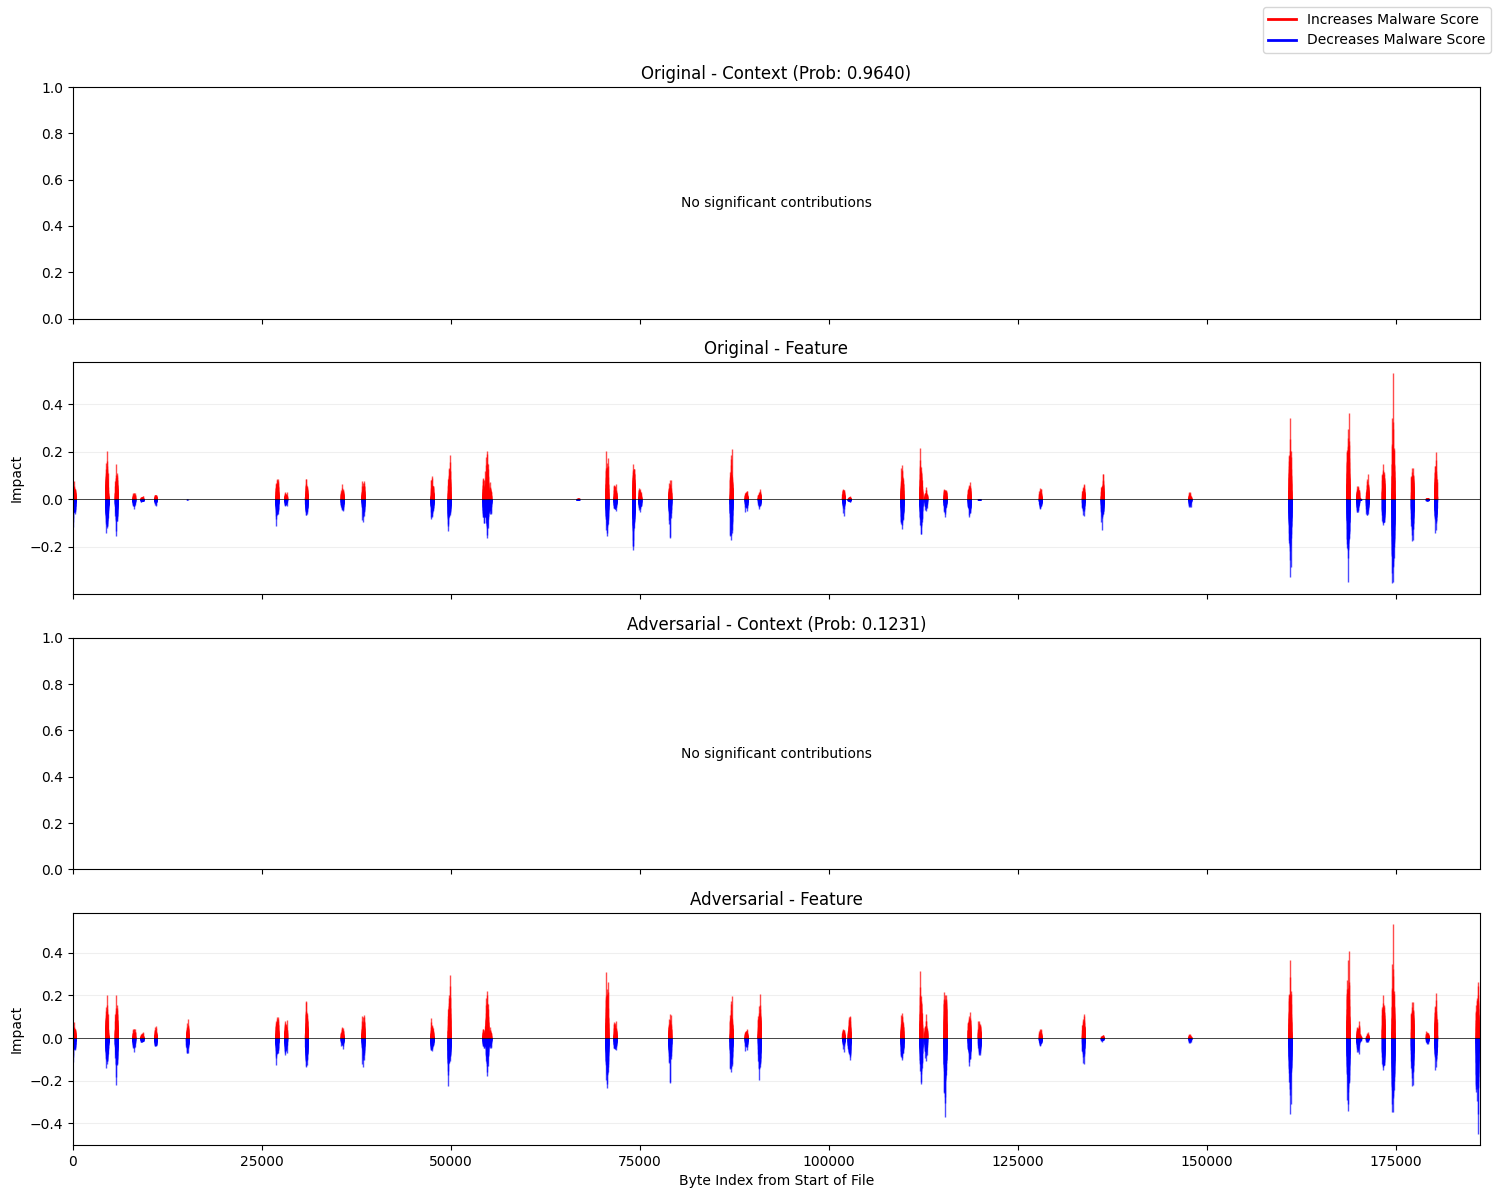


[6/7] Processing: Rustock_malware.exe
[16:38:21] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:21] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 1.2126
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 0.8646
    Model Out: 1.5463
    Diff     : 0.681736
    >> PASS: Additivity Verified.
[16:38:21] INFO  : Adversarial Attack Start: Original Size=269312, Padding Size(q)=2693, Iterations(T)=20
[16:38:22] INFO  : Success at iteration 1: Malware Prob = 0.0004
[16:38:22] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:22] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=96.50% -> Adversarial Prob=0.04%
  [Adversarial] Verifiction:
    SHAP Sum : -5.1515
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : -5.4995
    Model Out: -5.2624
    Diff     : 0.237126
    >> PASS: Additivity Verif

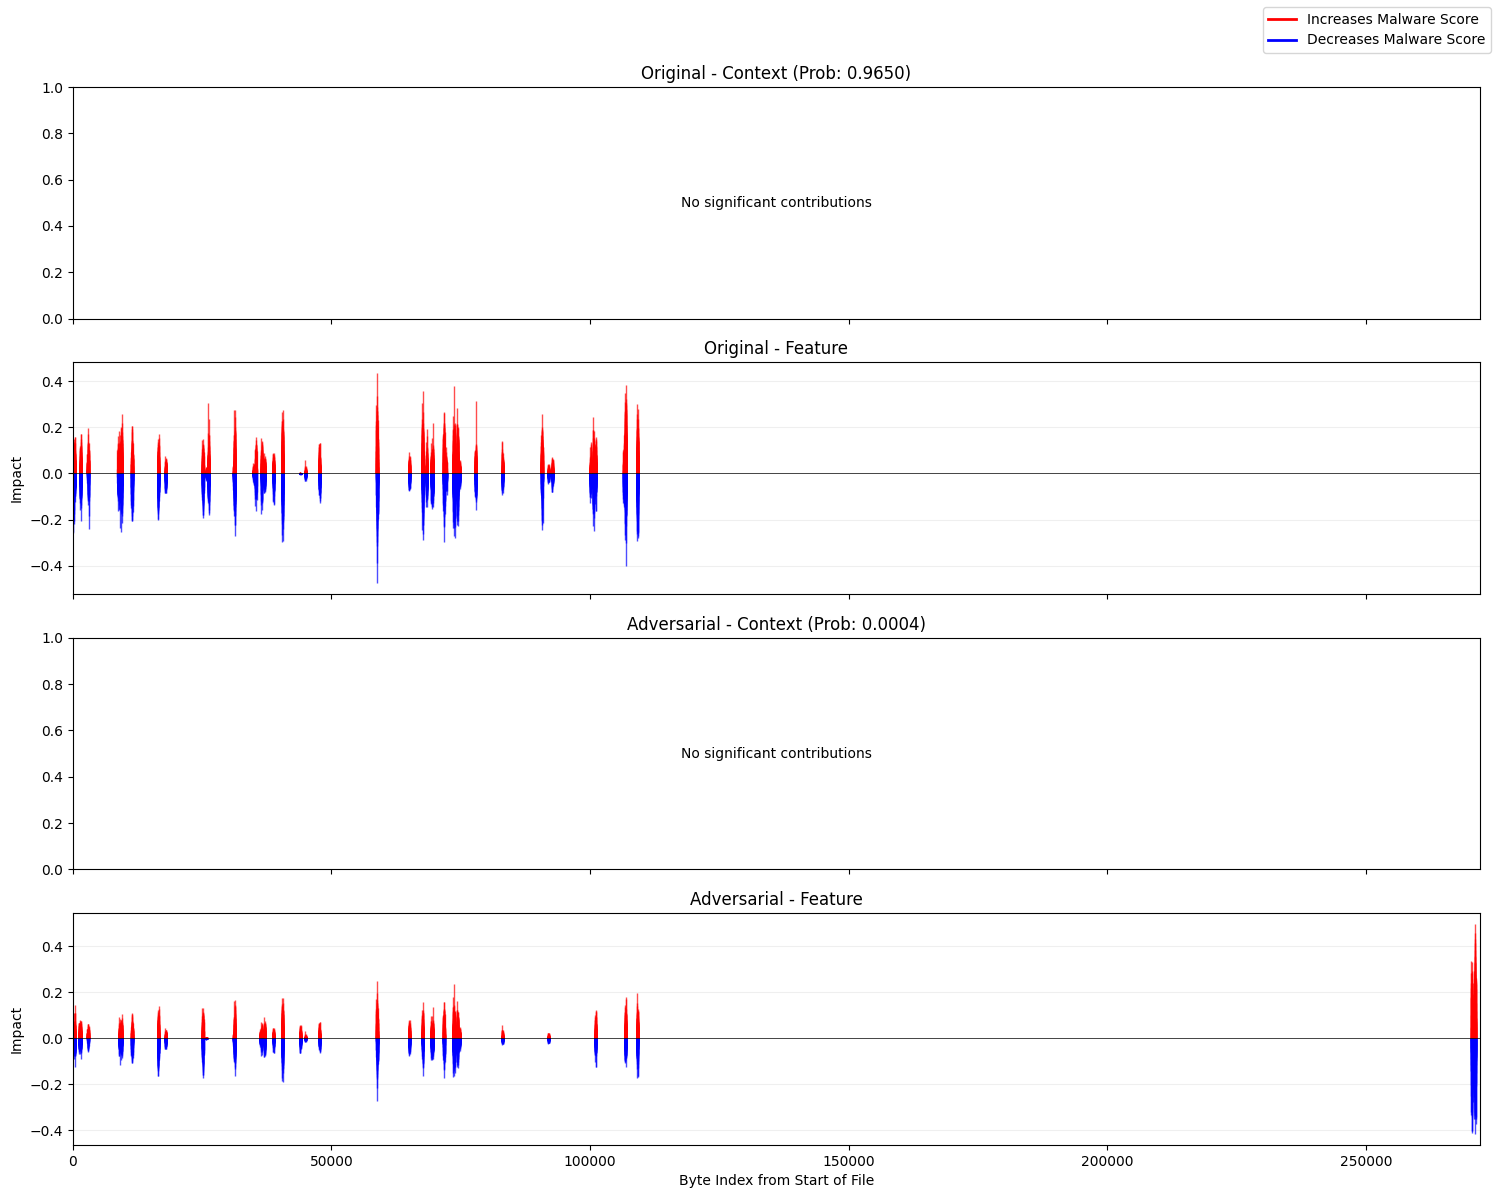


[7/7] Processing: win32_avatar
[16:38:22] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:22] INFO  : DeepSHAP explanation calculated successfully.
  [Original] Verifiction:
    SHAP Sum : 3.3762
    Base Val : -0.3480 (Model output on Zero Embeddings with Fixed Indices)
    Sum+Base : 3.0283
    Model Out: 2.6451
    Diff     : 0.383203
    >> PASS: Additivity Verified.
[16:38:22] INFO  : Adversarial Attack Start: Original Size=129024, Padding Size(q)=1290, Iterations(T)=20
[16:38:23] INFO  : Iteration 5/20: Malware Prob = 0.9960
[16:38:23] INFO  : Iteration 10/20: Malware Prob = 0.9960
[16:38:23] INFO  : Iteration 15/20: Malware Prob = 0.9960
[16:38:24] INFO  : Iteration 20/20: Malware Prob = 0.9960
[16:38:24] WARNING : Attack Failed to cross threshold after 20 iterations. Final Prob: 0.9960
[16:38:24] INFO  : SHAP Values Info: Type=<class 'numpy.ndarray'>, Len=N/A
[16:38:24] INFO  : DeepSHAP explanation calculated successfully.
  Result: Original Prob=99.60% 

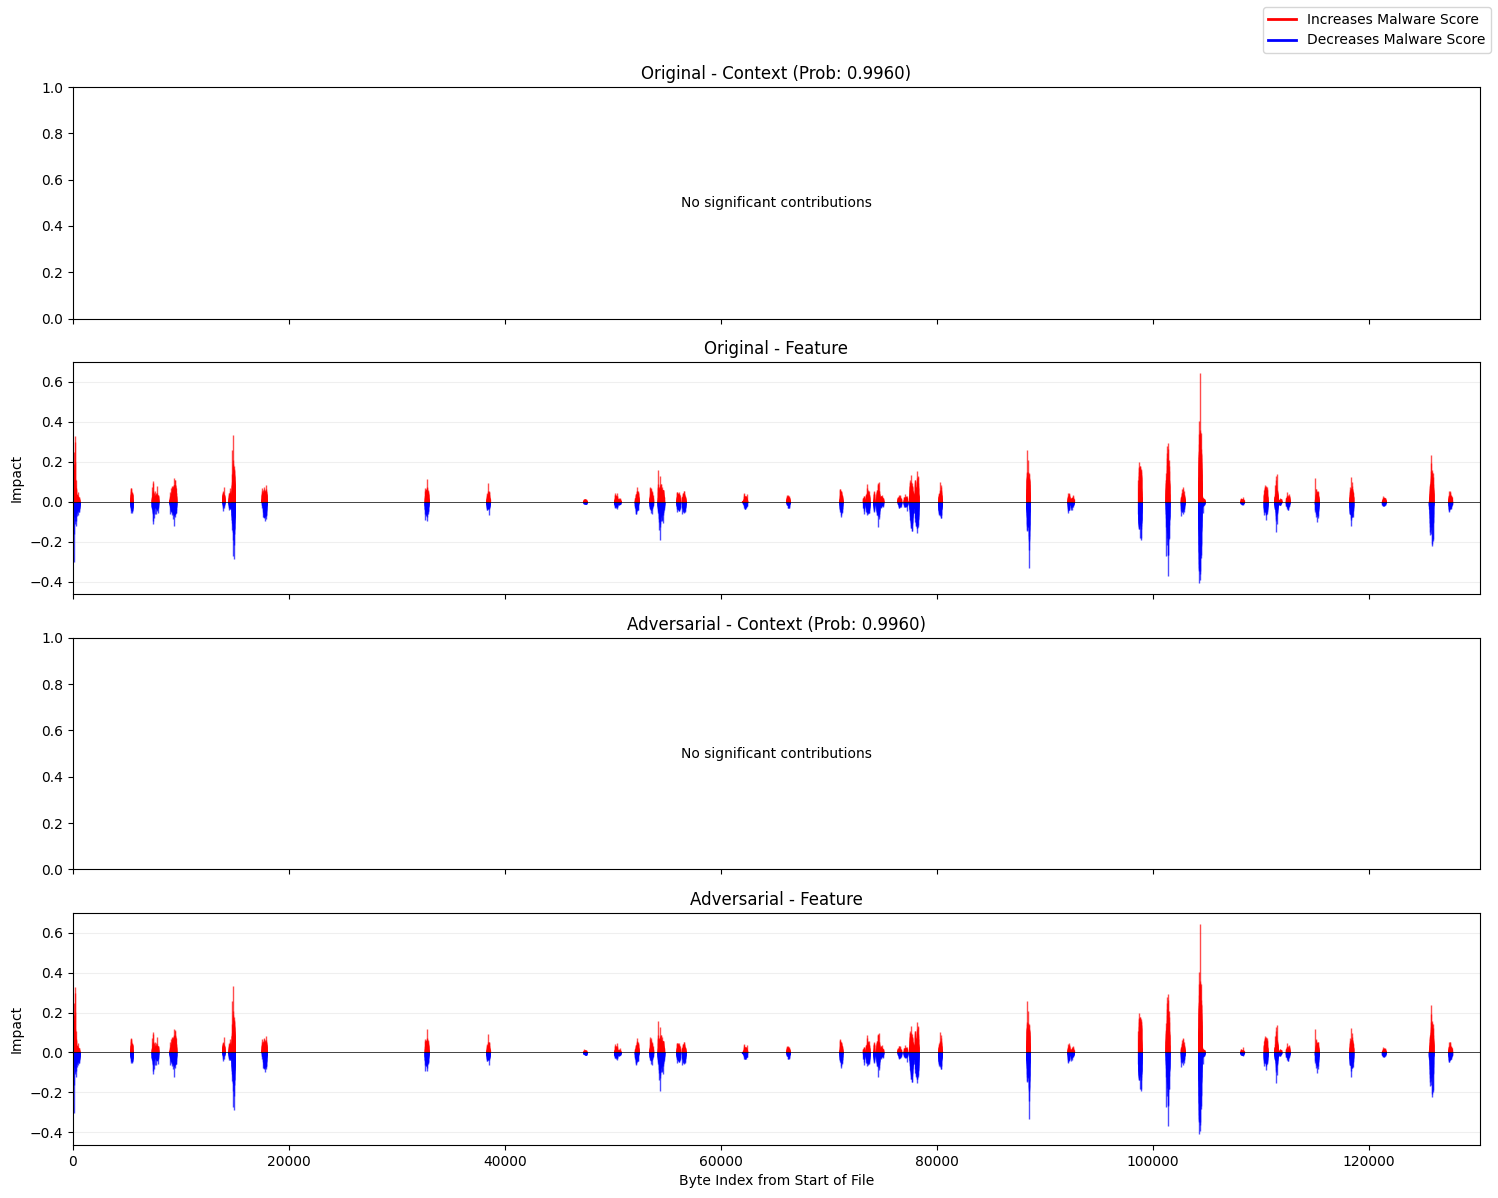


Comparison Complete.


In [1]:
# MalConvGCTDeepShap Adversarial Attack & Comparison Test
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib
import shap
from matplotlib.lines import Line2D

print("\n--- Testing Adversarial Attack & DeepSHAP Comparison ---")

# 1. Path Setup
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path: sys.path.append(src_path)

# MalConv2-main Path
possible_paths = [
    os.path.join(current_dir, '../models/MalConv2-main'),
    os.path.join(current_dir, 'MalConv2-main'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main'
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path: sys.path.append(malconv_path)
else:
    print("Warning: MalConv2-main path not found.")

# Reload Modules
try:
    import src.compute_DeepShap
    importlib.reload(src.compute_DeepShap)
    import src.adversarial_malware
    importlib.reload(src.adversarial_malware)
except Exception as e:
    print(f"Module reload warning: {e}")

from src.compute_DeepShap import MalConvGCTDeepShap
from src.adversarial_malware import generate_adversarial_example
from src import preprocess_pe_file

# Helper: Initialize New Model (Factory Function)
def create_new_model():
    """
    Creates a fresh instance of MalConvGCTDeepShap to avoid any state leakage.
    """
    channels = 256
    window_size = 256
    stride = 64
    embd_size = 8
    
    model = MalConvGCTDeepShap(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)
    
    if malconv_path:
        checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
        if os.path.exists(checkpoint_path):
            try:
                ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
                if 'model_state_dict' in ckpt:
                    model.load_state_dict(ckpt['model_state_dict'], strict=False)
                else:
                    model.load_state_dict(ckpt, strict=False)
            except Exception as e:
                print(f"Failed to load checkpoint: {e}")
                
    model.eval()
    return model

# 4. Data Setup
data_dir_candidates = [
    os.path.join(current_dir, '../data'),
    os.path.join(current_dir, 'data'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/data'
]
data_dir = None
for d in data_dir_candidates:
    if os.path.exists(d) and os.path.isdir(d):
        data_dir = d
        break

if not data_dir:
    print("Data directory not found!")
    files_to_process = []
else:
    files_to_process = [f for f in os.listdir(data_dir) if not f.startswith('.')]
    files_to_process = files_to_process[:7] # Limit to 7 files
    print(f"Target Files (Max 7): {files_to_process}")

# Helper: Discrete Plot
def plot_discrete_shap(ax, data, title, threshold=1e-5):
    if data.ndim > 1: data = data.flatten()
    
    # Filter by threshold
    active_mask = np.abs(data) > threshold
    indices = np.where(active_mask)[0]
    values = data[indices]
    
    if len(indices) == 0:
        ax.text(0.5, 0.5, "No significant contributions", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return

    colors = ['red' if v > 0 else 'blue' for v in values]
    
    ax.vlines(indices, 0, values, colors=colors, linewidth=1.0, alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.5)
    
    ax.set_title(title)
    ax.set_ylabel('Impact')
    ax.grid(True, alpha=0.2, axis='y')

# Helper: Verification
def verify_shap_additivity(model, shap_vals_sum, input_len, logic_logit, description):
    """
    Verifies that Sum(SHAP) + BaseValue == ModelOutput.
    BaseValue must be calculated using ZeroEmbeddings passed through the FIXED graph (saved indices).
    """
    device = next(model.parameters()).device
    
    # 1. Prepare Baseline (Zero Embeddings)
    # DeepSHAP uses Zero Embeddings as baseline
    embd_size = model.embd_size
    baseline_combined = torch.zeros((1, input_len, 2*embd_size)).to(device)
    
    # 2. Compute Base Value with FORCED Indices
    # We must enable _is_explaining on both main and context models to use saved_indices
    model._is_explaining = True
    if hasattr(model, "context_net"):
        model.context_net._is_explaining = True
        
    try:
        with torch.no_grad():
            base_logits = model(baseline_combined)
            # The model output is raw Logits.
            # We are verifying Class 1 (Malware) Logit.
            base_value = base_logits[0, 1].item()
    finally:
        model._is_explaining = False
        if hasattr(model, "context_net"):
            model.context_net._is_explaining = False
            
    # 3. Compare
    # SHAP Sum represents the change from Expected Value (Base Value) to Output
    # So: Output ≈ BaseValue + Sum(SHAP)
    reconstructed = shap_vals_sum + base_value
    diff = abs(reconstructed - logic_logit)
    
    print(f"  [{description}] Verifiction:")
    print(f"    SHAP Sum : {shap_vals_sum:.4f}")
    print(f"    Base Val : {base_value:.4f} (Model output on Zero Embeddings with Fixed Indices)")
    print(f"    Sum+Base : {reconstructed:.4f}")
    print(f"    Model Out: {logic_logit:.4f}")
    print(f"    Diff     : {diff:.6f}")
    
    if diff < 1.0:
        print("    >> PASS: Additivity Verified.")
    else:
        print("    >> FAIL: Additivity Mismatch.")
        

# 5. Process Loop
for idx, filename in enumerate(files_to_process):
    file_path = os.path.join(data_dir, filename)
    print(f"\n[{idx+1}/{len(files_to_process)}] Processing: {filename}")
    
    try:
        # Read Original Bytes
        with open(file_path, 'rb') as f:
            raw_bytes = f.read(4000000) # Max 4MB 
        orig_bytes = np.frombuffer(raw_bytes, dtype=np.uint8)
        
        # --- PHASE 1: Original Sample Analysis ---
        # Create FRESH model instance for Original
        model_orig = create_new_model()
        
        orig_tensor = torch.tensor(orig_bytes.astype(np.int32) + 1, dtype=torch.long).unsqueeze(0)
        
        # Inference & SHAP (Original)
        # 1. Clear saved indices to force fresh computation
        if hasattr(model_orig, "saved_indices"): model_orig.saved_indices = None
        if hasattr(model_orig.context_net, "saved_indices"): model_orig.context_net.saved_indices = None
        
        out_orig = model_orig(orig_tensor)
        logits_orig = out_orig[0]
        prob_orig = torch.nn.functional.softmax(logits_orig, dim=1)[0, 1].item()
        logit_orig_val = logits_orig[0, 1].item()
        shap_ctx_orig, shap_feat_orig = out_orig[3], out_orig[4]
        
        # Verify Original
        shap_sum_orig = np.sum(shap_ctx_orig) + np.sum(shap_feat_orig)
        verify_shap_additivity(model_orig, shap_sum_orig, len(orig_bytes), logit_orig_val, "Original")
        
        # --- PHASE 2: Attack Generation ---
        # Generate Adversarial Example using the Original Model
        # print("  Generating Adversarial Example...")
        adv_bytes = generate_adversarial_example(model_orig, orig_bytes, target_class=0)
        
        # Clean up model_orig to free memory/state
        del model_orig
        
        # --- PHASE 3: Adversarial Sample Analysis ---
        # Create FRESH model instance for Adversarial
        model_adv = create_new_model()
        
        adv_tensor = torch.tensor(adv_bytes.astype(np.int32) + 1, dtype=torch.long).unsqueeze(0)
        
        # Inference & SHAP (Adversarial)
        # 1. Clear saved indices to force fresh computation
        if hasattr(model_adv, "saved_indices"): model_adv.saved_indices = None
        if hasattr(model_adv.context_net, "saved_indices"): model_adv.context_net.saved_indices = None

        out_adv = model_adv(adv_tensor)
        logits_adv = out_adv[0]
        prob_adv = torch.nn.functional.softmax(logits_adv, dim=1)[0, 1].item()
        logit_adv_val = logits_adv[0, 1].item()
        shap_ctx_adv, shap_feat_adv = out_adv[3], out_adv[4]
        
        print(f"  Result: Original Prob={prob_orig*100:.2f}% -> Adversarial Prob={prob_adv*100:.2f}%")
        
        # Verify Adversarial
        shap_sum_adv = np.sum(shap_ctx_adv) + np.sum(shap_feat_adv)
        verify_shap_additivity(model_adv, shap_sum_adv, len(adv_bytes), logit_adv_val, "Adversarial")


        # 5. Visualization (Discrete Style)
        fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
        
        # Filter significant values for cleaner plot
        vis_threshold = 1e-5
        
        plot_discrete_shap(axes[0], shap_ctx_orig, f'Original - Context (Prob: {prob_orig:.4f})', vis_threshold)
        plot_discrete_shap(axes[1], shap_feat_orig, 'Original - Feature', vis_threshold)
        plot_discrete_shap(axes[2], shap_ctx_adv, f'Adversarial - Context (Prob: {prob_adv:.4f})', vis_threshold)
        plot_discrete_shap(axes[3], shap_feat_adv, 'Adversarial - Feature', vis_threshold)
        
        # Force X-Axis to show full file (Adversarial Length)
        total_len = len(adv_bytes)
        axes[3].set_xlim(0, total_len)
        
        custom_lines = [Line2D([0], [0], color='red', lw=2),
                        Line2D([0], [0], color='blue', lw=2)]
        fig.legend(custom_lines, ['Increases Malware Score', 'Decreases Malware Score'], loc='upper right')
        
        axes[3].set_xlabel('Byte Index from Start of File')
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()
        
        # Cleanup
        del model_adv

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()

print("\nComparison Complete.")